In [124]:
# load packages needed for this tutorial
using Revise
using Knockoffs
using Plots
using Random
using GLMNet
using Distributions
using LinearAlgebra
using ToeplitzMatrices
using StatsBase
using ProgressMeter
gr(fmt=:png);

In [77]:
function simulate_X_and_y(n, p; k = 50)
    # simulate X
    ρ = 0.4
    Σ = Matrix(SymmetricToeplitz(ρ.^(0:(p-1)))) # true covariance matrix
    μ = zeros(p) # true mean parameters
    L = cholesky(Σ).L
    X = randn(n, p) * L # var(X) = L var(N(0, 1)) L' = var(Σ)
    
    # simulate true beta
    βtrue = zeros(p)
    βtrue[1:k] .= randn(k)
    shuffle!(βtrue)

    # find true causal variables
    correct_position = findall(!iszero, βtrue)

    # simulate y
    y = X * βtrue + randn(n) 
    
    return X, y, βtrue, correct_position, Σ, μ
end

function run_standard_lasso(X, y, correct_positions)
    # run 10-fold cross validation to find best λ minimizing MSE
    lasso_cv = glmnetcv(X, y)
    λbest = lasso_cv.lambda[argmin(lasso_cv.meanloss)]

    # use λbest to fit LASSO on full data
    βlasso = glmnet(X, y, lambda=[λbest]).betas[:, 1]

    # check power and false discovery rate
    power = length(findall(!iszero, βlasso) ∩ correct_position) / length(correct_position)
    FDR = length(setdiff(findall(!iszero, βlasso), correct_position)) / max(1, count(!iszero, βlasso))
    return power, FDR
end

function run_single_knockoff(X, y, correct_position; target_fdr = 0.1)
    # run lasso on knockoffs
    knockoff_filter = fit_lasso(y, X, method=:mvr, fdrs=[target_fdr])
    
    # get resulting beta
    β_filtered = knockoff_filter.βs[1]
    
    # compute power and FDR
    power = length(findall(!iszero, β_filtered) ∩ correct_position) / length(correct_position)
    FDR = length(setdiff(findall(!iszero, β_filtered), correct_position)) / max(1, count(!iszero, β_filtered))
    return power, FDR
end

function run_multiple_knockoff(X, y, correct_position; m=2, target_fdr = 0.1)
    # run lasso on knockoffs
    knockoff_filter = fit_lasso(y, X, method=:mvr, m=m, fdrs=[target_fdr])
    
    # get resulting beta
    β_filtered = knockoff_filter.βs[1]
    
    # compute power and FDR
    power = length(findall(!iszero, β_filtered) ∩ correct_position) / length(correct_position)
    FDR = length(setdiff(findall(!iszero, β_filtered), correct_position)) / max(1, count(!iszero, β_filtered))
    return power, FDR
end

run_multiple_knockoff (generic function with 3 methods)

## Test run

In [80]:
n = 100
p = 500
k = 10
target_fdr = 0.1
X, y, βtrue, correct_position, Σ, μ = simulate_X_and_y(n, p, k=k)

@show power, fdr = run_standard_lasso(X, y, correct_position)
@show power, fdr = run_single_knockoff(X, y, correct_position, target_fdr=target_fdr)
@show power, fdr = run_multiple_knockoff(X, y, correct_position, m=2, target_fdr=target_fdr);

(power, fdr) = run_standard_lasso(X, y, correct_position) = (0.9, 0.8767123287671232)
(power, fdr) = run_single_knockoff(X, y, correct_position, target_fdr = target_fdr) = (0.0, 0.0)
(power, fdr) = run_multiple_knockoff(X, y, correct_position, m = 2, target_fdr = target_fdr) = (0.6, 0.14285714285714285)


## Repeat simulation in gimenez et al

In [125]:
ks = 1:15
n = 100
p = 500
target_fdr = 0.1
nsims = 50

one_ko_power, one_ko_fdr = zeros(ks), zeros(ks)
two_ko_power, two_ko_fdr = zeros(ks), zeros(ks)
three_ko_power, three_ko_fdr = zeros(ks), zeros(ks)

power_plt = plot(; xlim=(0, 16), xlabel="Number of non-null features", ylim=(0, 1), ylabel="Power")
fdr_plt = plot(; xlim=(0, 16), xlabel="Number of non-null features", ylim=(0, 0.3), ylabel="FDR")
hline!(fdr_plt, [target_fdr], label="Target FDR", w=3, color="black")

@showprogress for sim in 1:nsims
    for (idx, k) in enumerate(ks)
        X, y, βtrue, correct_position, Σ, μ = simulate_X_and_y(n, p, k=k)
        power, fdr = run_single_knockoff(X, y, correct_position, target_fdr=target_fdr)
        one_ko_power[idx] += power
        one_ko_fdr[idx] += fdr
        power, fdr = run_multiple_knockoff(X, y, correct_position, target_fdr=target_fdr, m=2)
        two_ko_power[idx] += power
        two_ko_fdr[idx] += fdr
        power, fdr = run_multiple_knockoff(X, y, correct_position, target_fdr=target_fdr, m=3)
        three_ko_power[idx] += power
        three_ko_fdr[idx] += fdr
        GC.gc();GC.gc();GC.gc()
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:24:43


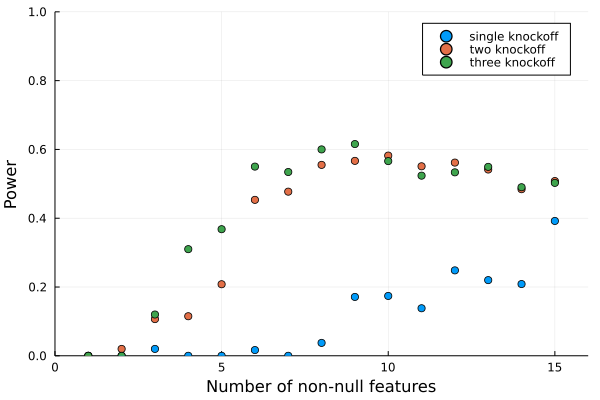

In [126]:
scatter!(power_plt, ks, one_ko_power ./ nsims, label="single knockoff")
scatter!(power_plt, ks, two_ko_power ./ nsims, label="two knockoff")
scatter!(power_plt, ks, three_ko_power ./ nsims, label="three knockoff")

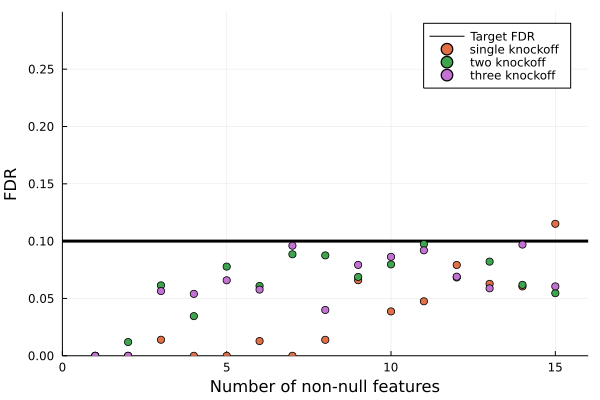

In [128]:
scatter!(fdr_plt, ks, one_ko_fdr ./ nsims, label="single knockoff")
scatter!(fdr_plt, ks, two_ko_fdr ./ nsims, label="two knockoff")
scatter!(fdr_plt, ks, three_ko_fdr ./ nsims, label="three knockoff")